In [41]:
import pandas as pd
import numpy as np
%matplotlib inline

In [42]:
data = pd.read_csv('winequality-red.csv')

In [43]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [44]:
data['quality'].value_counts().sort_index()

3     10
4     53
5    681
6    638
7    199
8     18
Name: quality, dtype: int64

In [45]:
data['vinho_bom'] = data['quality'].map(lambda x: 0 if x < 7 else 1)

In [46]:
data['vinho_bom'].value_counts().sort_index()

0    1382
1     217
Name: vinho_bom, dtype: int64

In [47]:
from lightgbm import LGBMClassifier

In [48]:
?LGBMClassifier

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data.iloc[:,:-2], data['vinho_bom'], train_size=0.5)

In [51]:
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((799, 11), (800, 11), (799,), (800,))

In [52]:
Xtrain.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
970,10.4,0.26,0.48,1.9,0.066,6.0,10.0,0.99724,3.33,0.87,10.9
842,10.6,0.50,0.45,2.6,0.119,34.0,68.0,0.99708,3.23,0.72,10.9
720,8.4,0.56,0.04,2.0,0.082,10.0,22.0,0.99760,3.22,0.44,9.6
524,9.2,0.43,0.49,2.4,0.086,23.0,116.0,0.99760,3.23,0.64,9.5
1284,7.0,0.42,0.19,2.3,0.071,18.0,36.0,0.99476,3.39,0.56,10.9


In [53]:
mdl = LGBMClassifier(random_state=0)
mdl.fit(Xtrain, ytrain)

LGBMClassifier(random_state=0)

In [54]:
from sklearn.metrics import roc_auc_score
p = mdl.predict_proba(Xtest)[:,1]

In [55]:
roc_auc_score(ytest, p)

0.9011072001726208

### Random search - busca aleatória

In [56]:
from skopt import dummy_minimize

In [57]:
def treinar_modelo(params):    
    # quanto cada árvore irá contribuir para as combinações 
    learning_rate = params[0]
    # número máximo de folhas do ultimo nível 
    num_leaves = params[1]
    # número de exemplos de cada nó
    min_child_samples = params[2]
    # ajuda a ter diversidade das arvores
    subsample = params[3]    
    colsample_bytree = params[4]
    
    print(f'\nparametros: {params}')
    # subsample_freq = 1 = cada árvore irá tirar uma amostra dos dados
    # n_estimators = números de árvores
    
    mdl = LGBMClassifier(learning_rate=learning_rate,num_leaves=num_leaves, min_child_samples=min_child_samples,
                        subsample=subsample,colsample_bytree=colsample_bytree, random_state=0, subsample_freq=1,
                        n_estimators=100)
    
    mdl.fit(Xtrain, ytrain)
    
    p = mdl.predict_proba(Xtest)[:,1]
    
    return -roc_auc_score(ytest, p)

# especificar o min, e max dos parametros
space= [(1e-3, 1e-1, 'log-uniform'), # log-uniform = dará mais peso para os números menores (isso é otimo pra learning_rate)
       (2,128),    # num_leaves
       (1,100),    # min_child_samples
       (0.05,1.0), # subsample
       (0.1,1.0)]   #colsample_bytree

# n_calls = numeros de amostras para testar
resultado = dummy_minimize(treinar_modelo, space, random_state=1, verbose=1, n_calls=30)


Iteration No: 1 started. Evaluating function at random point.

parametros: [0.09871192514273254, 74, 10, 0.3372159440002478, 0.23208030173540176]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1185
Function value obtained: -0.9000
Current minimum: -0.9000
Iteration No: 2 started. Evaluating function at random point.

parametros: [0.001529949829431263, 78, 72, 0.3782826906908954, 0.457090726807603]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0498
Function value obtained: -0.8690
Current minimum: -0.9000
Iteration No: 3 started. Evaluating function at random point.

parametros: [0.01195730942971637, 128, 19, 0.5483207515942279, 0.49910760440160107]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1084
Function value obtained: -0.8849
Current minimum: -0.9000
Iteration No: 4 started. Evaluating function at random point.

parametros: [0.0028784217488024557, 16, 51, 0.9182639233502714, 0.5114843271882895]
Iteration No: 4 

In [58]:
# resultado final, pode pegar apenas
resultado.x

[0.021930881089764206, 73, 4, 0.6880713925510277, 0.47060909107214777]

In [59]:
# aux = 0.9009 - [0.021930881089764206, 73, 4, 0.6880713925510277, 0.47060909107214777]

### Bayesian Optimization

In [61]:
from skopt import gp_minimize

In [62]:
resultados_gp = gp_minimize(treinar_modelo, space, random_state=1, verbose=1, n_calls=30, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.

parametros: [0.09871192514273254, 120, 14, 0.9990884895579377, 0.3124800792567785]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1883
Function value obtained: -0.9083
Current minimum: -0.9083
Iteration No: 2 started. Evaluating function at random point.

parametros: [0.006210998932353835, 51, 67, 0.9387621172657304, 0.8616798250174156]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0831
Function value obtained: -0.8793
Current minimum: -0.9083
Iteration No: 3 started. Evaluating function at random point.

parametros: [0.004232013397179603, 68, 45, 0.2680983530433343, 0.5809725180523154]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0631
Function value obtained: -0.8733
Current minimum: -0.9083
Iteration No: 4 started. Evaluating function at random point.

parametros: [0.0672858974212934, 60, 44, 0.9421713999524447, 0.8005503127028804]
Iteration No: 4 end

note que no ponto 11 ele está "Searching for the next optimal point.", isso 
sigfinica que a função está usando essas 10 combinação para achar o proximo ponto para explorar

In [ ]:
### exploration exploitation tradeoff

In [64]:
resultados_gp.x

[0.1, 49, 1, 0.7216739581279766, 0.7709654952674628]

In [68]:
print(f'resultado random search: {resultado.x}')
print(f'resultado bayesian optmization: {resultados_gp.x}')

resultado random search: [0.021930881089764206, 73, 4, 0.6880713925510277, 0.47060909107214777]
resultado bayesian optmization: [0.1, 49, 1, 0.7216739581279766, 0.7709654952674628]


In [65]:
from skopt.plots import plot_convergence

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

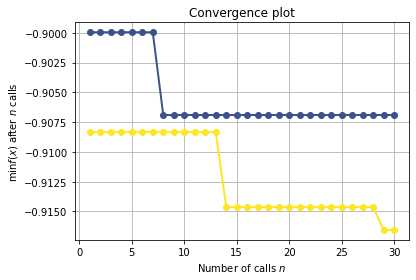

In [69]:
plot_convergence(resultado, resultados_gp)